In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [17]:
all_data = pd.read_csv("vgg16_cifar10.csv")
all_data.head()

,run,operation,started,time,status,label,blocker,data_location,dataset,gpu,...,Loss/postprune,Sparsity,best_post_acc,best_post_loss,best_pre_acc,best_pre_loss,immediate_post_acc,immediate_post_loss,Accuracy/preprune,Loss/preprune
0,b1ea195e,main.py,2022-05-27 22:59:54,1:31:57,completed,vgg16_cifar10,none,~/torch_subspace/data/,cifar10,cuda,...,2.302582,0.5994,0.1000,2.302495,0.9352,0.31292,0.1,2.302540,NaN,NaN
1,3238ec3e,main.py,2022-05-27 22:58:54,1:30:46,completed,vgg16_cifar10,none,~/torch_subspace/data/,cifar10,cuda,...,0.846878,0.9758,0.7723,0.817457,0.9352,0.31292,0.1,2.309226,NaN,NaN
2,5fbd0647,main.py,2022-05-27 21:42:37,1:25:19,completed,vgg16_cifar10,none,~/torch_subspace/data/,cifar10,cuda,...,0.693275,0.9802,0.7875,0.684371,0.9352,0.31292,0.1,2.310396,NaN,NaN
3,6ad0a77a,main.py,2022-05-27 21:42:37,1:24:39,completed,vgg16_cifar10,none,~/torch_subspace/data/,cifar10,cuda,...,2.302585,0.9850,0.1000,2.302543,0.9352,0.31292,0.1,2.304151,NaN,NaN
4,cffe0fe0,main.py,2022-05-27 21:42:36,1:17:17,completed,vgg16_cifar10,none,~/torch_subspace/data/,cifar10,cuda,...,0.914307,0.9882,0.6980,0.914307,0.9352,0.31292,0.1,2.308605,NaN,NaN


In [18]:
alignment_variance = pd.read_csv("sid_guild.csv")
alignment_variance = alignment_variance[alignment_variance["pruner"] == "alignment_variance"]
all_data = pd.concat([all_data, alignment_variance], axis="index", ignore_index=True)

In [19]:
all_data = all_data[["blocker", "pruner", "best_pre_acc", "best_post_acc", "Sparsity", "immediate_post_acc"]]
all_data["acc_drop"] = all_data["best_pre_acc"] - all_data["best_post_acc"]
all_data.head()

,blocker,pruner,best_pre_acc,best_post_acc,Sparsity,immediate_post_acc,acc_drop
0,none,alignment_output_sampling_proportional,0.9352,0.1000,0.5994,0.1,0.8352
1,none,alignment_output_sampling_proportional,0.9352,0.7723,0.9758,0.1,0.1629
2,none,alignment_output_sampling_proportional,0.9352,0.7875,0.9802,0.1,0.1477
3,none,alignment_output_sampling_proportional,0.9352,0.1000,0.9850,0.1,0.8352
4,none,alignment_output_sampling_proportional,0.9352,0.6980,0.9882,0.1,0.2372


In [20]:
alds_pruner_results = []
alds_keep_ratios = [0.850, 0.713, 0.598, 0.501, 0.420, 0.353, 0.296, 0.248, 0.208, 0.174, 0.146, 0.123, 0.103, 0.086, 0.072, 0.061, 0.051, 0.043, 0.036, 0.030]
alds_files = glob("./alds/*.csv")
for alds_file in alds_files:
    keep_ratio_index = int(alds_file.split("_")[-2][1:])
    sparsity = 1 - alds_keep_ratios[keep_ratio_index]
    training_run = pd.read_csv(alds_file)
    alds_pruner_results.append({
        "blocker": "true_alds",
        "pruner": "relative_error",
        "best_pre_acc": float("nan"),
        "best_post_acc": training_run["Value"].max(),
        "Sparsity": sparsity,
        "immediate_post_acc": float("nan"),
        "acc_drop": float("nan")
    })
alds_pruner_results = pd.DataFrame(alds_pruner_results)
all_data = pd.concat([all_data, alds_pruner_results], axis="index", ignore_index=True)

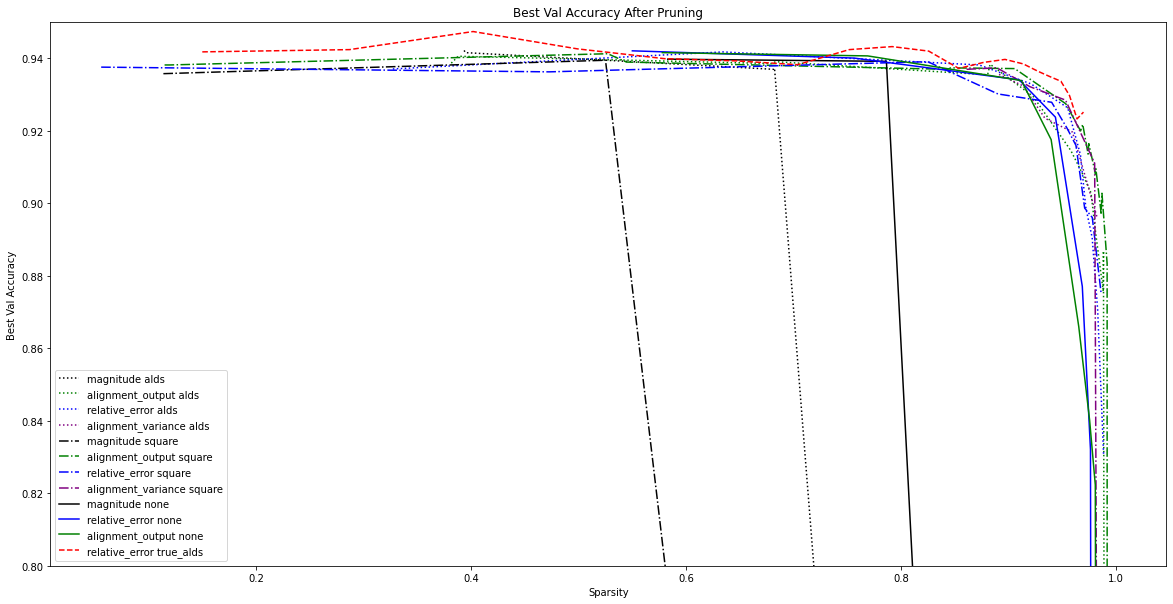

In [23]:
data = all_data[
    (all_data["pruner"] != "alignment_output_sampling") &
    (all_data["pruner"] != "alignment_output_sampling_proportional")
]
# data = all_data[all_data["blocker"] == "square"]
# data = all_data
plt.figure(figsize=(20, 10))
blocker_styles = {
    "none": "-",
    "alds": ":",
    "true_alds": "--",
    "square": "-.",
}
pruner_colors = {
    "magnitude": "black",
    "relative_error": "blue",
    "alignment_output": "green",
    "alignment_variance": "purple",
    "alignment_output_sampling": "red",
    "alignment_output_sampling_proportional": "black"
}
for blocker in data["blocker"].unique():
    b = data[data["blocker"] == blocker]
    for pruner in b["pruner"].unique():
        p = b[b["pruner"] == pruner].sort_values(by="Sparsity")
        color = "red" if blocker == "true_alds" else pruner_colors[pruner]
        plt.plot(
            p["Sparsity"],
            p["best_post_acc"],
            label=f"{pruner} {blocker}",
            linestyle=blocker_styles[blocker],
            color=color
        )
plt.legend()
plt.xlabel("Sparsity")
plt.ylabel("Best Val Accuracy")
plt.ylim(0.8, 0.95)
# plt.xlim(0.9, 0.995)
plt.title("Best Val Accuracy After Pruning")
plt.show()
